### Load required libraries

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Activation, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z']

df = pd.read_csv('./data/HAR/WISDM/WISDM.csv', index_col=0)
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


### Inspect Data

In [114]:
df['activity'].value_counts(normalize=True)

Walking       0.386447
Jogging       0.311578
Upstairs      0.111882
Downstairs    0.091447
Sitting       0.054579
Standing      0.044067
Name: activity, dtype: float64

In [115]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'], dtype='object')

### Data preprocessing

In [116]:
from pandas import DataFrame

sitting = df[df.activity=='Sitting'].sample(4499)
jogging = df[df.activity=='Jogging'].sample(4500)

sitting.iloc[:,1] = 0;
jogging.iloc[:,1] = 1;

sitting = sitting[['X','Y','Z', 'activity']]
jogging = jogging[['X','Y','Z', 'activity']]

resample = pd.concat([sitting, jogging])
resample = resample.sample(frac=1).reset_index(drop=True)
resample

,X,Y,Z,activity
0,0.11,-1.57,-6.320000,1
1,0.00,0.00,0.000000,1
2,2.37,2.26,8.960000,0
3,11.84,-18.85,4.100000,1
4,-6.66,-3.26,6.700000,0
...,...,...,...,...
8994,-2.41,3.57,4.099725,1
8995,-2.53,-0.84,-7.164303,1
8996,7.50,17.43,1.420000,1
8997,9.15,6.47,-8.010000,1


### Train/Test split

In [117]:
X_train, X_test = train_test_split(resample, test_size=0.2, random_state=42)
X_train = X_train[X_train.activity == 0]
X_train, y_train = X_train.drop(['activity'], axis=1), X_train['activity'];
X_train, y_train = X_train.values, y_train.values;

X_test, y_test = X_test.drop(['activity'], axis=1), X_test['activity']

X_test, y_test = X_test.values, y_test.values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (3620, 3)
X_test shape: (1800, 3)


In [118]:
X_test

array([[  4.29     ,  -6.7      ,  -0.23     ],
       [ -1.31     ,   3.64     ,  -7.89     ],
       [  0.57     ,  -2.98     ,  -2.9556155],
       ...,
       [-19.61     ,   0.76     ,   1.61     ],
       [ -6.21     ,   5.67     ,  -7.273266 ],
       [  7.97     ,   9.58     ,  10.501288 ]])

### Visualize the data with TSNE and PCA

In [32]:
x = resample.drop(['activity'],axis=1).values
y = resample['activity'].values

SEED = 42

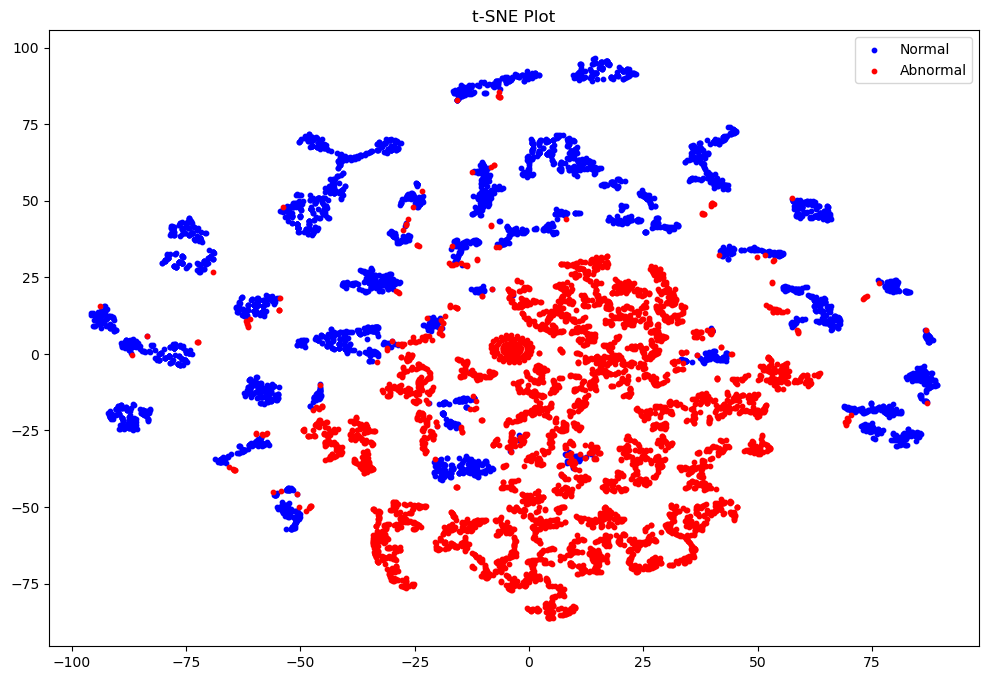

In [37]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('t-SNE Plot')
plt.legend()
plt.show()

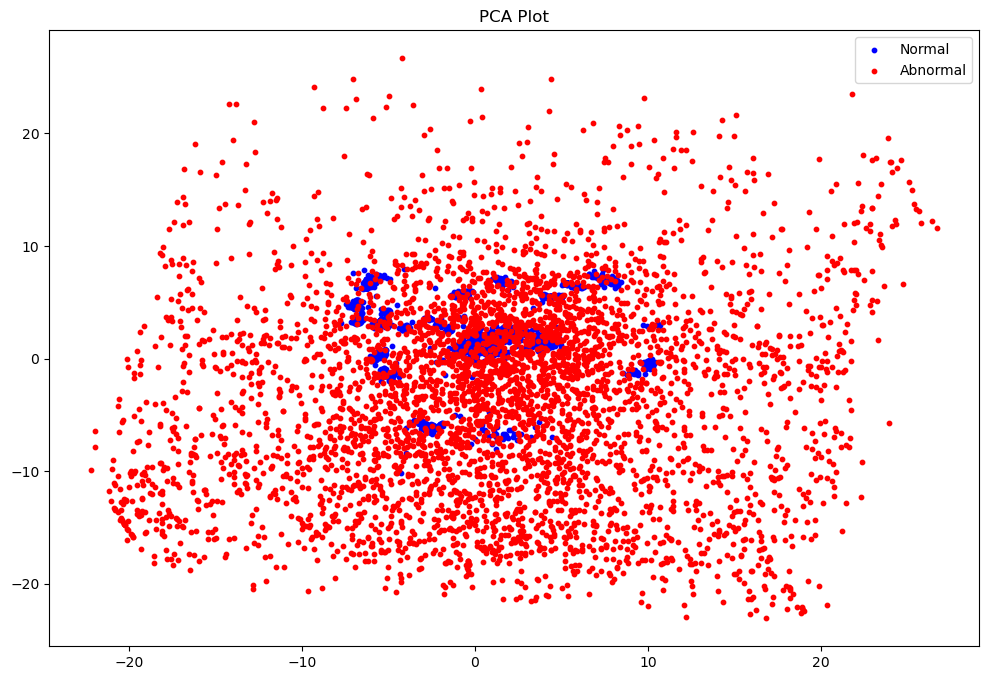

In [38]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal', s=10)
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Abnormal', s=10)
plt.title('PCA Plot')
plt.legend()
plt.show()

### Normalize Data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### GAN Model

In [145]:
def get_generator(input_dim):
    
    generator = Sequential()
    generator.add(Dense(6, activation="relu", input_dim=input_dim))
    
    generator.add(Dense(12, activation="relu"))

    generator.add(Dense(24, activation="relu"))
   
    generator.add(Dense(input_dim, activation='relu'))
    
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    
    return generator

In [146]:
def get_discriminator(input_dim):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(24, activation="relu", input_dim=input_dim))

    discriminator.add(Dense(12, activation="relu"))
       
    discriminator.add(Dense(6, activation="relu"))

    discriminator.add(Dense(1, activation='sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    return discriminator

In [147]:
def get_GAN(discriminator, generator, input_dim):

    discriminator.trainable = False   
    
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    
    return gan

### Training

In [148]:
batch_size = 64
epochs = 5
input_dim = X_train.shape[1]

batch_count = X_train.shape[0] // batch_size
gan_loss = []
discriminator_loss = []

generator = get_generator(input_dim)
discriminator = get_discriminator(input_dim)
gan = get_GAN(discriminator, generator, input_dim)


for epoch in range(epochs):        
    for index in range(batch_count):        
    
        noise = np.random.normal(0, 1, size=[batch_size, input_dim])
        generated_images = generator.predict_on_batch(noise)
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        noise = np.random.uniform(0, 1, size=[batch_size, input_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

Epoch 0 Batch 55/56 [D loss: 0.378602] [G loss:0.758355]
Epoch 1 Batch 55/56 [D loss: 0.237421] [G loss:1.155494]
Epoch 2 Batch 55/56 [D loss: 0.165399] [G loss:1.573101]
Epoch 3 Batch 55/56 [D loss: 0.104786] [G loss:1.561886]
Epoch 4 Batch 55/56 [D loss: 0.047347] [G loss:2.417707]


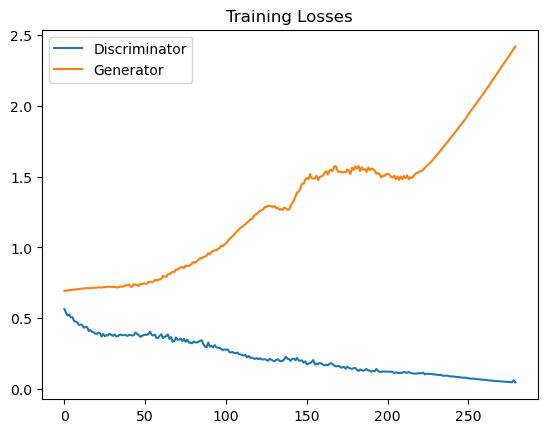

In [149]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

### Test Data

In [166]:
nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=batch_size,verbose=0)        
        results = np.append(results, tmp_rslt)  

In [167]:
y_pred = results.copy()

In [168]:
y_pred

array([0.97671241, 0.99989915, 0.18250321, ..., 0.99999976, 0.99999774,
       0.99999994])

<Axes: ylabel='Density'>

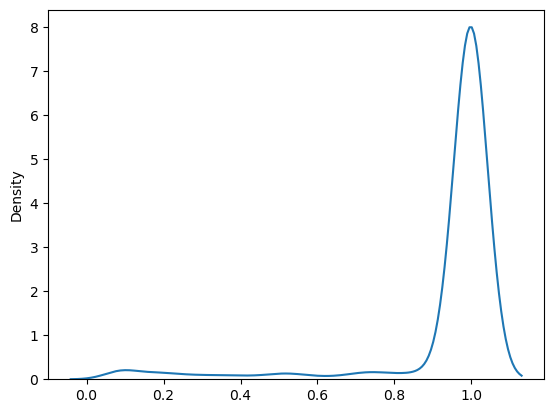

In [169]:
sns.kdeplot(y_pred)

In [170]:
# 0가까이로 예측된 값도 존재하지만 모델이 불안정하여 1로 쏠려서 예측하는 것을 확인할 수 있다.

bce = K.eval(binary_crossentropy(y_test, y_pred))
error_df = pd.DataFrame({'bce_error': bce,
                        'true_class': y_test})
error_df.describe()

,bce_error,true_class
count,1.800000e+03,1800.000000
mean,3.846341e+00,0.511667
std,3.775807e-14,0.500003
min,3.846341e+00,0.000000
25%,3.846341e+00,0.000000
50%,3.846341e+00,1.000000
75%,3.846341e+00,1.000000
max,3.846341e+00,1.000000


In [175]:
threshold = 3.846341

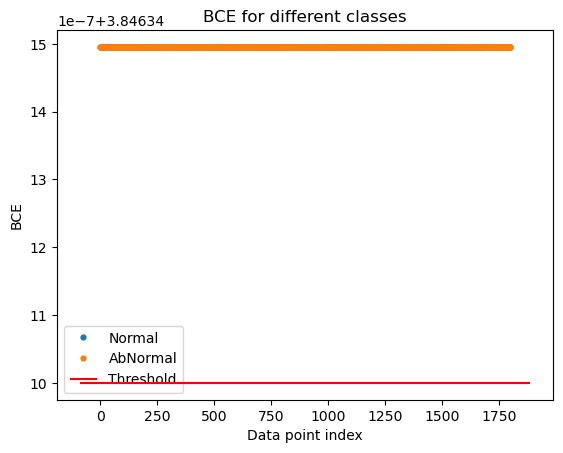

In [176]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.bce_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "AbNormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("BCE for different classes")
plt.ylabel("BCE")
plt.xlabel("Data point index")
plt.show();

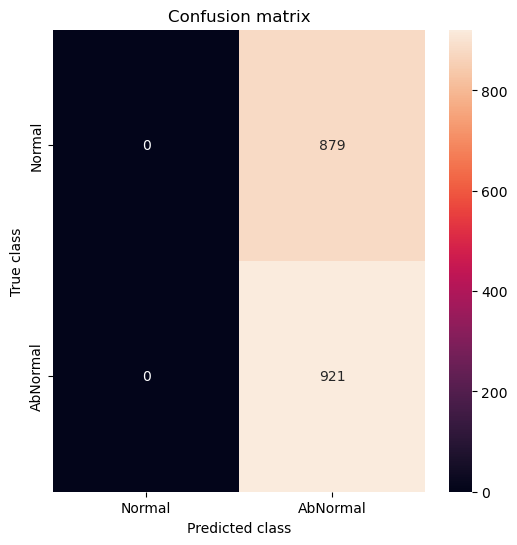

In [177]:
LABELS = ["Normal", "AbNormal"]

y_pred = [1 if e > threshold else 0 for e in error_df.bce_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [178]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5116666666666667
Precision : 0.5116666666666667
Recall : 1.0
F1 : 0.6769570011025359
